In [1]:
import logging
# Set the logging level to ERROR
logging.getLogger("dask").setLevel(logging.ERROR)

import re
import json
import shutil
from functools import wraps
import pandas as pd
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask import delayed
from cluster_config import create_local_cluster

### Clean up previous run ###
# Specify the path to the dask-worker-space folder
dask_worker_space_path = "./dask-worker-space"
# Remove the folder if it exists
shutil.rmtree(dask_worker_space_path, ignore_errors=True)

# Create a local cluster with multiple processes
cluster = create_local_cluster()

# Connect a Dask client to the cluster
client = Client(cluster)

# Define data types for selected columns in a dictionary
dtypes = {
    'id': 'object',
    'submitter':'object',
    'authors':'object',
    'title':'object',
    'comments': 'object',
    'journal-ref': 'object',
    'doi': 'object',
    'report-no': 'object',
    'categories': 'object',
    'license': 'object',
    'abstract':'object',
    'versions':'object',
    'update_date':'datetime',
    'authors_parsed':'object',
}

df = dd.read_json(
    './arXiv/arxiv-metadata-oai-snapshot.json',
    blocksize='8MB', 
    dtype=dtypes,
    )

# Show original arXiv Dask DataFrame
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [2]:
#########################
### FEATURE SELECTION ###
#########################

# Keep only the following columns / discard irrelevant columns
# The title and abstract contain most detailed / specific information about the papers content. Tokenized / TF-IDF
# The categories represent the subject area where the paper belongs, these show a more global scope. 
# Categories are limited in number and these could be turned into one-hot encoding or used with label encoding.
# The update_date is crucial for tracking temporal changes and understanding how the trends evolve over time.

columns_to_keep = ['title', 'abstract', 'categories', 'update_date']
df = df[columns_to_keep]

# Verify data types
print(f'Dask DataFrame Datatypes:\n{df.dtypes}')

Dask DataFrame Datatypes:
title          object
abstract       object
categories     object
update_date    object
dtype: object


In [3]:
# Define a regular expression pattern for 'YYYY-MM-DD' format
date_pattern = r'^\d{4}-\d{2}-\d{2}$'

# Use the 'str.match' method to check if each entry follows the format
invalid_dates = df[~df['update_date'].str.match(date_pattern, na=False)].compute()
print('Invalid Dates DataFrame (empty means no invalid dates):\n',invalid_dates.head(10))
# All dates follow the YYYY-MM-DD format

# Now that the strings are checked lets change the dtype to datetime
df['update_date'] = dd.to_datetime(df['update_date'], format='%Y-%m-%d')

# Release invalid_dates from memory
del invalid_dates

Invalid Dates DataFrame (empty means no invalid dates):
 Empty DataFrame
Columns: [title, abstract, categories, update_date]
Index: []


In [4]:
# Clean up old garbage
client.restart()

#########################
##### PREPROCESSING #####
#########################

### Function declarations for .apply()
# Remove LaTeX markup
def remove_latex_markup(text):
    # Use regex to match LaTeX expressions and remove them
    return re.sub(r'\$\$.*?\$\$|\$.*?\$', '', text)

# Replace specific LaTeX expressions, symbols can be important for understanding the paper
# E.g. "$\Lambda_{\alpha}$" to lambda_alpha
def replace_latex_symbols(text):
    # Define a mapping of LaTeX symbols and their replacements
    latex_mappings = {
        r'$\Lambda_{\alpha}$': 'Lambda alpha',
        # Add more mappings as needed
    }
    
    # Replace LaTeX symbols with their text representations
    for latex, replacement in latex_mappings.items():
        text = text.replace(latex, replacement)
    
    return text

### Execute text cleaning
# Data cleaning and preprocessing for text data (chained operations)

# Define metadata for the output of the apply function
meta_title = ('title', 'object')
df['title'] = (
    df['title']
    .str.lower()
    .str.replace('[^\w\s]', '')  # Remove special characters
    .apply(remove_latex_markup, meta=meta_title)   # Remove LaTeX markup and replace LaTeX symbols
    .apply(replace_latex_symbols, meta=meta_title)
)

meta_abstract = ('abstract', 'object')
df['abstract'] = (
    df['abstract']
    .str.lower()
    .str.replace('[^\w\s]', '')  # Remove special characters
    .apply(remove_latex_markup, meta=meta_abstract)   # Remove LaTeX markup and replace LaTeX symbols
    .apply(replace_latex_symbols, meta=meta_abstract)
)

### After cleaning titles can appear to be the same, hence we do it afterwards.
# Handle missing values and duplicates
df = df.dropna(subset=['title', 'abstract'])
df = df.drop_duplicates()

### Show new dataframe with cleaned text columns
df.head()

,title,abstract,categories,update_date
0,calculation of prompt diphoton production cros...,a fully differential calculation in perturba...,hep-ph,2008-11-26
1,sparsitycertifying graph decompositions,we describe a new algorithm the kellpebble g...,math.CO cs.CG,2008-12-13
2,the evolution of the earthmoon system based on...,the evolution of earthmoon system is describ...,physics.gen-ph,2008-01-13
3,a determinant of stirling cycle numbers counts...,we show that a determinant of stirling cycle...,math.CO,2007-05-23
4,from dyadic lambda_alpha to lambda_alpha,in this paper we show how to compute the lam...,math.CA math.FA,2013-10-15


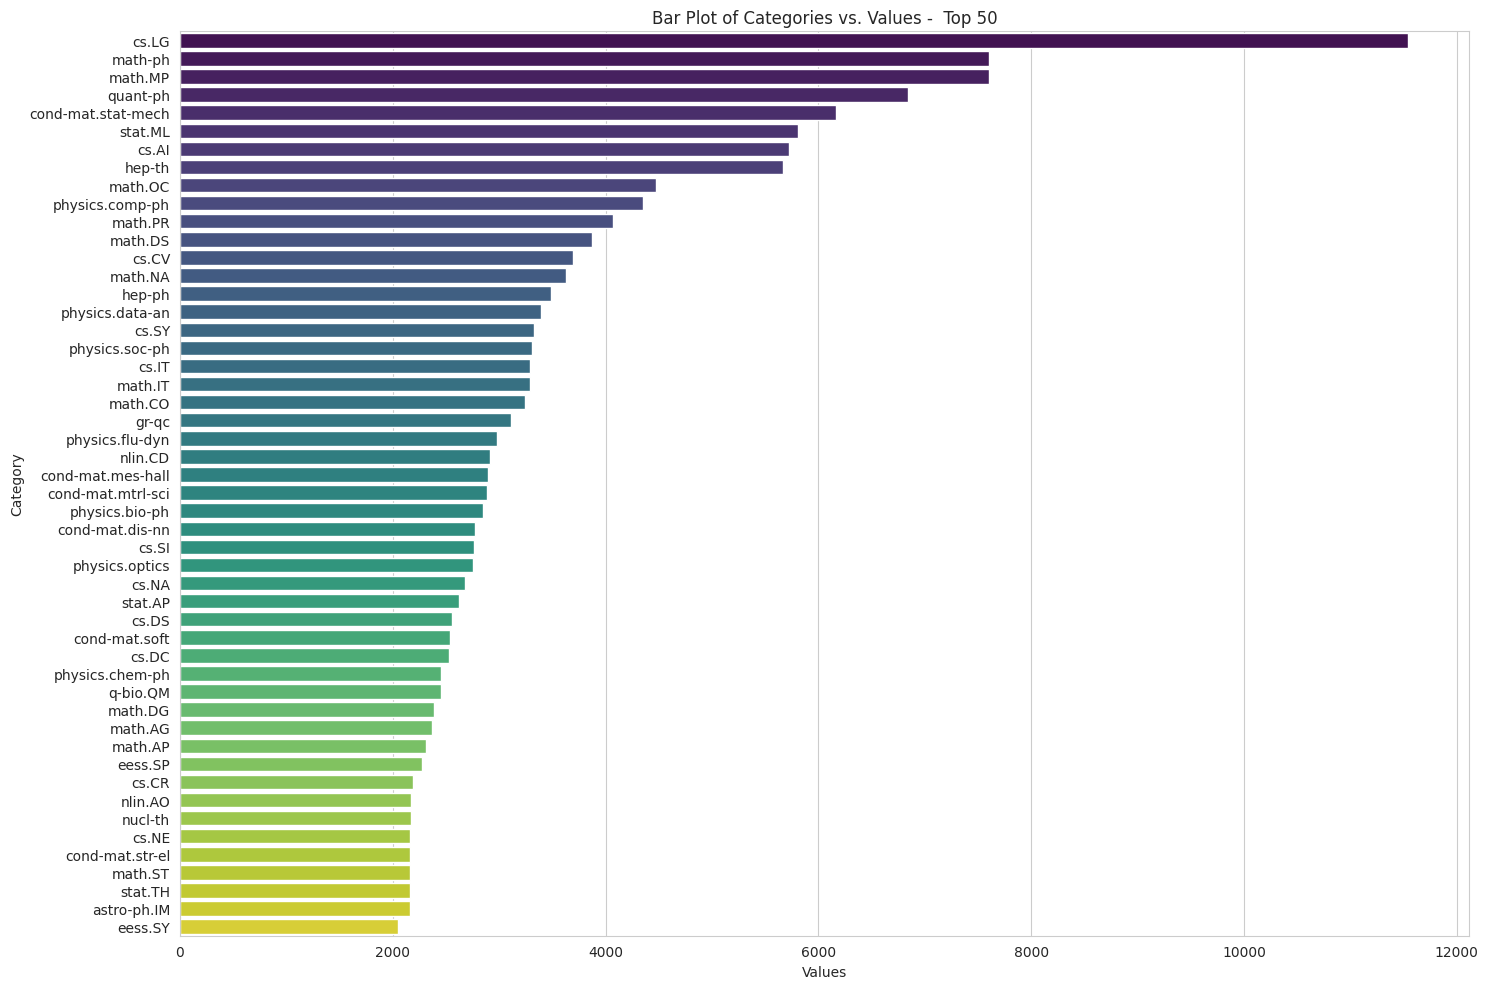

Total of unique categories:  176


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean up old garbage
client.restart()

####################################
###### Exploring Categories ########
####################################

# The categories are labeled with codes, e.g. "math.IT" or "astro-ph.HE".
# Some of these have become outdated as they have been replaced by other aliases.
# In arxiv-cat-scrape.ipynb we webscrape the latest available categories which are saved under arXiv-categories-YYYY-MM-DD.json
# We compare the categories in the dataset against what is currently available so the codes can be resolved in the future.

# Extract unique categories
unique_categories = df['categories'].unique().compute()
unique_set = set()

# Now, `loaded_dict` contains the contents of the JSON file
for index, key in enumerate(sorted(unique_categories)):
    for cat in key.split(" "):
        unique_set.add(cat)

dict_cat_freq = {}
# Exploring the frequencies for each category
for key in unique_categories:
    cat_list = key.split(" ")
    for cat in cat_list:
        if cat not in dict_cat_freq:
            dict_cat_freq[cat] = 0
        else:
            dict_cat_freq[cat] += 1

# Sort dictonary by most frequent category descending    
data = dict(sorted(dict_cat_freq.items(), key=lambda item: item[1], reverse=True))
df_freq = pd.DataFrame.from_dict(data, orient='index', columns=['Values'])

# Set Seaborn style to "whitegrid"
sns.set_style("whitegrid")

# Visualizing the most common categories
plt.figure(figsize=(15, 10))  
sns.barplot(x='Values', y=df_freq.index[:50], data=df_freq[:50], palette='viridis')
plt.xlabel('Values')
plt.ylabel('Category')
plt.title('Bar Plot of Categories vs. Values - Top 50')

plt.tight_layout()  # Ensure labels are not cut off
plt.show()

print("Total of unique categories: ",len(unique_set))

In [12]:
dask.config.set({"distributed.comm.retry.count": 10})
dask.config.set({"distributed.comm.timeouts.connect": 30})

# Clean up old garbage
client.restart()

###################################
### Cleaning categories column ####
###################################

# Any category code that is not in the webscraped categories taxonomy will be dropped.
# In total it's only 6403 rows from 2.1M+ total rows
# Read the JSON file and load it into a dictionary

arXiv_categories_file = './arXiv/arXiv-categories-only-code-2023-10-09.json'
with open(arXiv_categories_file, 'r') as category_json:
    category_list = json.load(category_json)

y = [ x['code'] for x in category_list]
deprecated_cat = unique_set.difference(set(y))

# Check if any of the categories in the list is present in each row's 'categories' column
# Create a boolean mask indicating which rows contain one of the specified categories
first_category = df['categories'].str.split().str[0]
num_category = df['categories'].str.split().str.len()
mask = first_category.isin(deprecated_cat)

# Filter the DataFrame to get the rows containing the specified categories
# Clean up old garbage
client.restart()

filtered_df = df[mask].compute()

# Clean up old garbage
client.restart()

filtered_df_one_cat = df[mask & (num_category < 2)].compute()

# These are all the categories that are not found in arXiv-categories-YYYY-MM-DD.json
# Not present on https://arxiv.org/category_taxonomy which is source for the json file.
# This affects over 1 million rows! Even if we look for rows which only have 1 category which is from the deprecated_cat it still counts over 400K rows.
print(f'There are {len(filtered_df)} rows that contain a deprecated_cat value.')
print(f'There are {len(filtered_df_one_cat)} rows that contain a deprecated_cat value and contain only one category.')

# All deprecated_cat values, we will need to resolve these because missing count is too large to drop, even for single categories with deprecated values.
deprecated_cat

# Cleaning up memory from unused objects
del first_category
del num_category
del mask
del filtered_df
del filtered_df_one_cat


distributed.nanny - WARNING - Worker process still alive after 1.5999986648559572 seconds, killing


There are 675077 rows that contain a deprecated_cat value.
There are 412192 rows that contain a deprecated_cat value and contain only one category.


In [13]:
# Taxonomy only works for python < 3.7.0 so we access it in this way. The folder is from https://github.com/arXiv/arxiv-base
from arXiv.taxonomy import definitions

resolved_categories = []

print('Total Deprecated: ', len(deprecated_cat))
found = 0

for code in deprecated_cat:
    if code in definitions.CATEGORIES:
        category = definitions.CATEGORIES[code]
        if 'name' in category:
            if 'description' in category:
                description = category['description']
            else:
                description = category['in_archive'] + ' is archived.'
            name = category['name']
            resolved_categories.append(
                {
                    "code": code,
                    "name": name,
                    "description": description
                }
            )
            found += 1
    else:
        print('Not found for: ', code)

print('Total Resolved: ', found)
for line in resolved_categories:
    print(line)

# Lets join the resolved_categories with category_list
category_list = category_list + resolved_categories

# Compare the set of unique categories from the categories column to the categories codes resolved
categories_fixed_set = set([x['code'] for x in category_list])
number_of_missing_categories  = len(unique_set.difference(categories_fixed_set)) # Calculate the len of the difference set, if 0 then we have no missing
print('\nTotal remaining missing categories code: ',number_of_missing_categories)

# Write the updated dictionary with deprecated fix to the a new JSON file (artifact)
with open('.'+arXiv_categories_file.split('.')[1]+'-deprecated-fixed.json', 'w') as json_file:
    json.dump(category_list, json_file, indent=4)
    print('\nFile has been written to: ',arXiv_categories_file+'-deprecated-fixed.json')

# Cleaning up memory
del resolved_categories
del category_list
del deprecated_cat
del unique_set
del categories_fixed_set


Total Deprecated:  34
Total Resolved:  34
{'code': 'bayes-an', 'name': 'Bayesian Analysis', 'description': 'bayes-an is archived.'}
{'code': 'astro-ph.CO', 'name': 'Cosmology and Nongalactic Astrophysics', 'description': 'Phenomenology of early universe, cosmic microwave background, cosmological parameters, primordial element abundances, extragalactic distance scale, large-scale structure of the universe. Groups, superclusters, voids, intergalactic medium. Particle astrophysics: dark energy, dark matter, baryogenesis, leptogenesis, inflationary models, reheating, monopoles, WIMPs, cosmic strings, primordial black holes, cosmological gravitational radiation'}
{'code': 'q-alg', 'name': 'Quantum Algebra and Topology', 'description': 'q-alg is archived.'}
{'code': 'cmp-lg', 'name': 'Computation and Language', 'description': 'cmp-lg is archived.'}
{'code': 'cond-mat', 'name': 'Condensed Matter', 'description': 'cond-mat is archived.'}
{'code': 'hep-th', 'name': 'High Energy Physics - Theory

In [15]:
# Clean up old garbage
client.restart()
############################
#### Category Enconding ####
############################

# Extract unique categories
unique_categories = df['categories'].unique().compute()

# Create a dictionary to map categories to numerical codes
category_mapping = {cat: code for code, cat in enumerate(unique_categories)}

# Show what the dictonary labeling looks like
print(category_mapping)

# Write the dictionary to the JSON file
with open('./arXiv/category_labeling.json', 'w') as json_file:
    json.dump(category_mapping, json_file, indent=4)

# E.g. Categories: math-ph chao-dyn math.MP math.NT math.SP nlin.CD quant-ph
# Where this paper has primary classification math-ph and 
# secondary classifications chao-dyn math.MP math.NT math.SP nlin.CD quant-ph (sorted in alphabetical order). 
# Except in cases of subsumed archives (e.g. alg-geom to math.AG), the primary classification match the first part of the identifier at present. 
# We may, at some later time, abandon that rule to allow reclassification of old articles to any category.

{'hep-ph': 0, 'math.CO cs.CG': 1, 'physics.gen-ph': 2, 'math.CO': 3, 'math.CA math.FA': 4, 'cond-mat.mes-hall': 5, 'gr-qc': 6, 'cond-mat.mtrl-sci': 7, 'astro-ph': 8, 'math.NT math.AG': 9, 'math.NT': 10, 'math.CA math.AT': 11, 'hep-th': 12, 'math.PR math.AG': 13, 'hep-ex': 14, 'nlin.PS physics.chem-ph q-bio.MN': 15, 'math.NA': 16, 'nlin.PS': 17, 'cond-mat.str-el cond-mat.stat-mech': 18, 'math.RA': 19, 'math.CA math.PR': 20, 'cond-mat.str-el': 21, 'physics.optics physics.comp-ph': 22, 'q-bio.PE q-bio.CB quant-ph': 23, 'q-bio.QM q-bio.MN': 24, 'hep-ph hep-lat nucl-th': 25, 'math.OA math.FA': 26, 'math.QA math-ph math.MP': 27, 'physics.gen-ph quant-ph': 28, 'cond-mat.stat-mech cond-mat.mtrl-sci': 29, 'astro-ph nlin.CD physics.plasm-ph physics.space-ph': 30, 'nlin.PS nlin.SI': 31, 'quant-ph cs.IT math.IT': 32, 'cs.NE cs.AI': 33, 'gr-qc astro-ph': 34, 'physics.ed-ph quant-ph': 35, 'math.DG gr-qc': 36, 'cond-mat.soft cond-mat.mtrl-sci': 37, 'physics.pop-ph': 38, 'nucl-th': 39, 'math.FA': 40, 

In [18]:
# Clean up old garbage
client.restart()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  # Import the WordNet lemmatizer
import string

# Download the NLTK datasets (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # Download WordNet data for lemmatization

# Create a WordNet lemmatizer instance
lemmatizer = WordNetLemmatizer()

# Define a function for text preprocessing with lemmatization
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Define a set of English stopwords from NLTK
    stop_words = set(stopwords.words('english'))
    
    # Lemmatize the words and remove stopwords
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join the filtered words back into a sentence
    return ' '.join(filtered_words)

# Apply the preprocessing function to the 'title' and 'abstract' columns using map_partitions
df['title'] = df['title'].map(preprocess_text, meta=('title', 'str'))
df['abstract'] = df['abstract'].map(preprocess_text, meta=('abstract', 'str'))

# Display the updated DataFrame
df.head()

# Use the to_parquet method to write the Dask DataFrame to Parquet files
df.to_parquet('./processing/stage_1_text_preprocessed', engine='pyarrow')


[nltk_data] Downloading package punkt to /home/fox/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fox/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fox/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
